In [3]:
%load_ext autoreload
%autoreload 2

# CIS 399 Homework 3: Algorithmic Fairness

## Sophia Trump

In this homework, you will gain experience with tools for implementing classifiers that provide fairness guarantees. In part 2, you will try to get a fair classifier if you only have access to a normal classifier. In parts 3 and 4, you will get to explore the different outcomes when using different definitions of fairness for classifiers. You will also look at the tradeoffs between fairness and accuracy. 

All cells where code is required are marked with a "YOUR CODE HERE" comment. The point values for each code block are written in the header for the associated subsection.


## Part 1: Importing Data (5 Points)
Before working with the algorithms for fair classification, we must first import the dataset we wish to use. We will again be working with the "Communities and Crime" dataset from [UC Irvine's Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/communities+and+crime). It includes data about the different types of crimes among various communities, socioeconomic and racial data about each community, and information about the police force in each community.

The algorithms will require that your data is split into 3 DataFrames:

- `dataX`: The features of each instance, not including any protected attributes
- `dataA`: The protected attributes of each instance
- `dataY`: The label for each instance

Currently, we provide you with 2 CSV files:

- `communities.csv`, which contains all information for each instance
- `communities_protected.csv`, which labels each column as 1 if the attribute is a protected feature, 2 if the attribute is the label for the instance, and 0 otherwise. In part 2, we will focus on only one of the sensitive features. In parts 3 and 4, we will use all 18 sensitive features for upholding our fairness metrics.

Write code to generate the 3 Pandas DataFrames, `dataX`, `dataA` and `dataY`. Print the size of each dataframe when you are finished.

In [4]:
import pandas as pd
import numpy as np

# Suppressing warnings
import warnings
warnings.filterwarnings('ignore') 

## YOUR CODE HERE
dataframe1 = pd.read_csv("communities.csv")
dataframe2 = pd.read_csv("communities_protected.csv")

# get the values for dataframe2 (so it is iterable in next step)
data2 = dataframe2.values[:,:]
data2 = data2.ravel()

#separate protected attributes, unprotected attributes, and labels into 3 separate lists
protectedCol = [] 
unprotectedCol = [] 
label = []
for i in range(0, len(dataframe1.columns.values), 1):
    if(data2[i] == 0): #not protected
        unprotectedCol.append(dataframe1.columns[i])
    if(data2[i] == 1): #protected
        protectedCol.append(dataframe1.columns[i]) 
    if(data2[i] == 2): #a label
        label.append(dataframe1.columns[i])
        
#make the dataX, dataA, and dataY arrays by dropping by column label (as created in the previous step)
dataX = dataframe1.drop(protectedCol, axis = 1)
dataX = dataX.drop(label, axis = 1) #drop the label column

dataA = dataframe1.drop(unprotectedCol, axis = 1)
dataA = dataA.drop(label, axis = 1) #drop the label column

dataY = dataframe1.drop(protectedCol, axis = 1)
dataY = dataY.drop(unprotectedCol, axis = 1)
            
print('dataX Shape:', dataX.shape)
print('dataA Shape:', dataA.shape)
print('dataY Shape:', dataY.shape)

dataX Shape: (1994, 104)
dataA Shape: (1994, 18)
dataY Shape: (1994, 1)


## Part 2: Two-Group Fairness via Post-processing (35 Points)

In this section, you will implement a method of achieving a fair classifier "from scratch" by post-processing a generic linear regression classifier. This method is described in https://arxiv.org/abs/1610.02413 and was discussed in Lecture 10 (https://www.seas.upenn.edu/~cis399/files/lecture/l10.pdf). 

Here, you will train a classifier which approximately equalizes both True Positive Rate and False Positive Rate for two groups (which we generate for you), which is commonly referred to as the Equalized Odds criterion.

### 2.1: Training a Real-Valued Predictor (5 points)

Fairness postprocessing requires training a model which predicts real-valued scores (such as the estimated probability of a positive label) rather than just predicting 0 or 1. 

Use the Linear Regression package from SciKit-Learn to train a regression model on dataX and dataY. Generate predictions for dataY (called y_hat_score) and print them.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [5]:
## YOUR CODE HERE

from sklearn.linear_model import LinearRegression

logreg = LinearRegression().fit(dataX, dataY)
y_hat_score = logreg.predict(dataX)
print(y_hat_score) 

[[0.25785039]
 [0.20704865]
 [0.45755179]
 ...
 [0.65533497]
 [0.09814837]
 [0.73405048]]


### 2.2: Binary Classification via Thresholding (5 points)

Write a function (threshold_predictions) which takes in a set of predicted scores and a threshold, and converts the scores to 0/1 predictions (below or equal to threshold = 0, above threshold = 1). Print out your converted predictions using a threshold of 0.5.

In [6]:
## YOUR CODE HERE

def threshold_predictions(y_hat_score, threshold):
    converted_predictions = []
    for i in range(0, len(y_hat_score)):
        if(y_hat_score[i] <= threshold):
            converted_predictions.append(0)
        else:
            converted_predictions.append(1)
    return converted_predictions

y_hat_0_1 = threshold_predictions(y_hat_score, 0.5)
print(y_hat_0_1)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 

### 2.3: Computing TPR and FPR (5 points)

Write functions which compute the true positive rate and false positive rate, given vectors for true labels (y) and binary predictions (y_hat). Returning to the confusion matrix from HW2, recall that FPR = B/(B+D) and TPR = A/(A+C):
https://www.seas.upenn.edu/~cis399/HW2_CIS399.pdf

Compute the TPR and FPR for your predictions from 2.2.



In [7]:
## YOUR CODE HERE

def true_positive_rate(y, y_hat): #ASSUMES y IS A 1D ARRAY
    true_positives = 0
    false_negatives = 0
    
    for i in range(0, len(y)):
        if((y[i] == 1) and (y_hat[i] == 1)): #true positive?
            true_positives += 1
        elif((y[i] == 1) and (y_hat[i] == 0)): #false negative?
            false_negatives+= 1
    return (true_positives)/(true_positives+false_negatives)
        
def false_positive_rate(y, y_hat):
    false_positives = 0
    true_negatives = 0
    
    for i in range(0, len(y)):
        if((y[i] == 0) and (y_hat[i] == 1)): #false positive?
            false_positives += 1
        elif((y[i] == 0) and (y_hat[i] == 0)): #true negative?
            true_negatives += 1
    return (false_positives)/(false_positives+true_negatives)


#convert dataY to 1d array
y = dataY.values[:,:]
y = y.ravel()

print(true_positive_rate(y, y_hat_0_1))
print(false_positive_rate(y, y_hat_0_1))

0.7032590051457976
0.05669737774627923


### 2.4: Computing ROC Curves (5 points)

ROC (receiver operating characteristic) curves measure the tradeoff between true positive and false positive rates when thresholding a real-valued predictor: https://en.wikipedia.org/wiki/Receiver_operating_characteristic 

Write a function that takes in a set of {0,1} true labels (such as dataY), a set of [0,1] predictions (such as y_hat_score), and a single integer, `num_thresholds`, reprensting the number of thresholds. Evenly divide the range [0,1] into `num_thresolds` equally sized intervals. For each interval, use the bottom of the interval as a threshold,  threshold the real-valued predictions to {0,1} predictions (as in 2.2), and compute the TPR and FPR of the thresolded predictions.

For example, if num_thresholds = 100, your thresholds should be 0.00, 0.01, 0.02, ... , 0.99.

Compute arrays of TPR and FPR values using dataY and y_hat score with 100 thresholds.

In [8]:
## YOUR CODE HERE

def compute_roc_curve(y, y_hat_score, num_thresholds): #ASSUMES y IS A 1D ARRAY
    tpr = []
    fpr = []
    
    # evenly divide the range [0,1] into num_thresholds equally sized intervals
    inc_by = 1/num_thresholds
    steps = []
    i = 0.00
    while(i < 1):
        steps.append(i)
        i += inc_by
        
    for i in range(0, len(steps)):
        y_hat_local = threshold_predictions(y_hat_score, steps[i]) #use the bottom of the interval as a threshold, threshold the real-valued predictions to {0,1} predictions (as in 2.2)
        tpr.append(true_positive_rate(y, y_hat_local)) #compute TPR of the threshold predictions
        fpr.append(false_positive_rate(y, y_hat_local)) #compute FPR of the threshold predictions
    
    return tpr, fpr

#convert dataY to 1d array
y = dataY.values[:,:]
y = y.ravel()

tpr, fpr = compute_roc_curve(y, y_hat_score, 100)

### 2.5: ROC Curve Comparison (5 points)

The code below is copied from our solution to Homework 1 and splits the data into two groups (A and B), based on whether the proportion of black people in the community is greater than 50%. Run the cell below.

Using the generated arrays (X_A, X_B, y_A, y_B) and your function from 2.4, produce a matplotlib plot showing the ROC curves for each group with 100 threshold values. Use your trained linear regression model for predictions. Your X axis should be FPR and your Y axis should be TPR. Refer to Homework 1 for a reminder on how to use matplotlib.

In [9]:
## RUN THIS CELL
## DO NOT MODIFY

def split_on_feature(dataX, dataY, dataA, column, thresh):
    rows_A = []
    rows_B = []
    for i in range(dataX.shape[0]):
        if dataA[i, column] < thresh:
            rows_A.append(i)
        else:
            rows_B.append(i)
    
    X_A = dataX[rows_A, :]
    X_B = dataX[rows_B, :]
    y_A = dataY[rows_A]
    y_B = dataY[rows_B]
    
    return X_A, X_B, y_A, y_B  


# change 2 to whatever racepctblack is
X_A, X_B, y_A, y_B = split_on_feature(dataX.values, dataY.values, dataA.values, 0, 0.5)

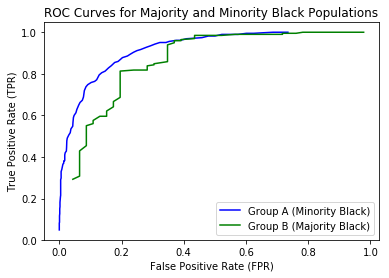

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt

## YOUR CODE HERE

# predict for Groups A and B
groupA_y_hat_score = logreg.predict(X_A)
groupB_y_hat_score = logreg.predict(X_B)

# Compute TPR and FPR for each group with 100 thresholds
groupA_TPR, groupA_FPR = compute_roc_curve(y_A, groupA_y_hat_score, 100)
groupB_TPR, groupB_FPR = compute_roc_curve(y_B, groupB_y_hat_score, 100)

# Create a plot with a caption, X and Y legends, etc
x_label = 'False Positive Rate (FPR)'
y_label = 'True Positive Rate (TPR)'
plt.title('ROC Curves for Majority and Minority Black Populations')
plt.xlabel(x_label)
plt.ylabel(y_label)

plt.plot(groupA_FPR, groupA_TPR, color='blue', label='Group A (Minority Black)') ## (x, y, ...)
plt.plot(groupB_FPR, groupB_TPR, color='green', label='Group B (Majority Black)')
plt.legend()

plt.show()

### 2.6: Minimizing Unfairness (5 points)

There are 10,000 possible pairs of thresholds of the form $(a,b)$ where $a$ is the threshold for A and $b$ is the threshold for B in data plotted above. Find and print out the pair which minimizes  $|TPR_A - TPR_B| + |FPR_A - FPR_B|$. You can think of this as finding points which are closest between the two ROC curves.

In [11]:
## YOUR CODE HERE
currentMinimum = abs(groupA_TPR[0] - groupB_TPR[0]) + abs(groupA_FPR[0] - groupB_FPR[0]) #assume first points are the minimum
min_unfairness_A_thresh = 0
min_unfairness_B_thresh = 0

# create an array (steps[]) that contains all thresholds used to create groupA_TPR/FPR and groupB_TPR/FPR
# number of steps as above is 100
inc_by = 1/100
steps = []
i = 0.00
while(i < 1):
    steps.append(i)
    i += inc_by

for a in range(0, 100): # for all a thresholds
    for b in range(0,100): # for all b thresholds
        localValue = abs(groupA_TPR[a] - groupB_TPR[b]) + abs(groupA_FPR[a] - groupB_FPR[b])
        if(localValue < currentMinimum):
            currentMinimum = localValue
            min_unfairness_A_thresh = steps[a] #find the corresponding threshold in steps[a]/steps[b]
            min_unfairness_B_thresh = steps[b]

print((min_unfairness_A_thresh, min_unfairness_B_thresh))

(0.11999999999999998, 0.5000000000000002)


### 2.7: Evaluating Accuracy (5 points)

Compute the overall "fair" error when using the thresholds from 2.6 on their respective groups. Compare this to the minimum achievable error when using the single best threshold in {0.00, 0.01, 0.02, ... , 0.99} for both groups.

As with HW1, you should calculate the percentage of labels that are misclassified as your error metric.

In [99]:
## YOUR CODE HERE

# error calculation function, taken HW1. returns loss instead of error
# this is so each group's error rate can be combined in the next cell
def error(y, y_hat):
    loss = 0
    
    ## check that parameters are correctly formatted
    if(not(len(y) == len(y_hat))):
        raise Exception("Unequal parameter lengths")
    
    for i in range(0, len(y)):
        if(not(y[i] == y_hat[i])):
            loss += 1
            
    return loss

In [103]:
## YOUR CODE HERE

# predict for Groups A and B
groupA_y_hat_score = logreg.predict(X_A)
groupB_y_hat_score = logreg.predict(X_B)

#compute the error each group with each threshold from 2.6
#get the predictions for each group
groupA_threshold_fairness = threshold_predictions(groupA_y_hat_score, min_unfairness_A_thresh)
groupB_threshold_fairness = threshold_predictions(groupB_y_hat_score, min_unfairness_B_thresh)

#get the number of errors for each group
groupA_fairness_loss = error(y_A, groupA_threshold_predictions)
groupB_fairness_loss = error(y_B, groupB_threshold_predictions)

# calculate the overall fairness error using the loss and length of y for each group
fair_err = (groupA_fairness_loss + groupB_fairness_loss)/(len(y_A) + len(y_B))


#compute the minimum error
#set initial min_err
groupA_threshold_min = threshold_predictions(groupA_y_hat_score, steps[0])
groupB_threshold_min = threshold_predictions(groupB_y_hat_score, steps[0])
    
groupA_min_loss = error(y_A, groupA_threshold_min)
groupB_min_loss = error(y_B, groupB_threshold_min)
    
min_err = (groupA_min_loss + groupB_min_loss)/(len(y_A) + len(y_B))

for s in steps:
    groupA_threshold_min = threshold_predictions(groupA_y_hat_score, s)
    groupB_threshold_min = threshold_predictions(groupB_y_hat_score, s)
    
    groupA_min_loss = error(y_A, groupA_threshold_min)
    groupB_min_loss = error(y_B, groupB_threshold_min)
    
    local_min_error = (groupA_min_loss + groupB_min_loss)/(len(y_A) + len(y_B))
    if(local_min_error < min_err):
        min_err = local_min_error
    

print((min_err, fair_err))

(0.1213640922768305, 0.3159478435305918)


## Part 3: Marginal Group Fairness via Cost-Sensitive Reduction (15 Points)

In this section, you will implement models from Microsoft Research (MSR), which use cost-sensitive classification in order to generate classifiers which satisfy particular fairness metrics. The algorithm is derived in [A Reductions Approach to Fair Classification](https://arxiv.org/pdf/1803.02453.pdf) and was discussed in lecture: https://www.seas.upenn.edu/~cis399/files/lecture/l10.pdf.

### 3.1: Importing the MSR code (5 Points)
The version of the MSR code has been provided in the same directory as this notebook. Run the following command to make sure that the notebook is able to run the code.

In [104]:
## Run this cell
!python test_fairlearn.py

import marginal_fair
## Expected Output:
# testing (DP, eps=0.100): ok

testing (DP, eps=0.100): ok


### 3.2: Marginal Fairness (5 Points)
In this section, you will analyze a classifier that is marginally fair with respect to the protected attributes.

The current implementation of the MSR code allows for one protected attribute at a time, so we have provided a file `marginal_fair.py` which generalizes the MSR code to allow for more than one protected attribute.

At the bottom of `marginal_fair.py`, you will find a function `run_eps_single`, which runs this algorithm. The function takes in 4 arguments: `eps`, `x`, `a`, and `y`. `x`, `a`, and `y` correspond to `dataX`, `dataA`, and `dataY`, respectively, and `eps` is a parameter which measures the allowed statistical unfairness of a classifier (in this case, we are looking at false positive disparity rates).

Using `run_eps_single`, get the predictions of the marginally fair classifier for `eps = 0.01` and report the overall error of this classifier.

In [ ]:
## YOUR CODE HERE

### 3.3: Pareto Curve for Marginally Fair Classifier (5 Points)
By varying the parameter `eps`, construct a Pareto curve that measures the error of the classifier as the allowed fairness violation changes.

Use the following values for `eps`: `.005, .01, .075, .14, .2`

When the code is complete, plot your results using `matplotlib`, as you did in Homework 1.

In [ ]:
## YOUR CODE HERE

## Part 4: Subgroup Fairness via Cost-Sensitive Reduction (20 Points)

Now, you will implement models which are fair with respect to subgroups of a population, as described in [Preventing Fairness Gerrymandering: Auditing and Learning for Subgroup Fairness](https://arxiv.org/abs/1711.05144v5) and in lecture: https://www.seas.upenn.edu/~cis399/files/lecture/l11.pdf.

To start, you should clone [GerryFair repository](https://github.com/algowatchpenn/GerryFair) from github and add the `gerryfair/` folder to the same directory as this notebook.

You can run the following two cells to clone the repository and use the code to clean the dataset and provide three numpy arrays as outputs.

You should note that the first cell also copies over a Jupyter notebook that demos the functionality of the codebase. **Before jumping into each section of this part, we advise that you run through the relevant part of the demo as well as read through the relevant part of the codebase.**

In [ ]:
## RUN THIS CELL
## DO NOT MODIFY

# This clones the the github repository into a local folder
!git clone https://github.com/algowatchpenn/GerryFair.git ../GerryFair
    
# Copy the core code and the demo into the current folder.
!mkdir gerryfair
!cp -r ../GerryFair/gerryfair/. gerryfair/
!cp ../GerryFair/GerryFair\ Demo.ipynb gerryfair_demo.ipynb

import gerryfair

### 4.1 Auditing a classifier (5 Points)

Using the `gerryfair.model.Auditor` class, audit the predictions from Part 2 to find a subgroup that violates the fairness disparity metric. In this case, we will use false positive as our fairness disparity metric. The `audit` function may be helpful for finding a subgroup that violates the fairness metric and getting the fairness disparity. Print the fairness disparity for this subgroup.

In [ ]:
## YOUR CODE HERE

### 4.2: Constructing a Subgroup Fair Classifier (5 Points)

Now, you will construct a model which is fair with respect to all subgroups of the population. Using the `gerryfair.model.Model` class, create a classifier with the following parameters: set `gamma` to be .01, `max_iters` to be 20, and leave the rest to their default values.

Train the model and create in-sample predictions for our data (Use all of `dataX`, `dataA`, and `dataY` for both training and testing). Print out the error of the predictions.

In [ ]:
## YOUR CODE HERE

### 4.3: Analysis of a Subgroup Fair Classifier (5 points)

Now, let's audit the predictions of the new model. Similar to Section 3.2, use an auditor to find a group that violates the fairness disparity metric. Print out the fairness disparity for this group. How does it compare to the fairness disaprity of the previous model?

In [ ]:
## YOUR CODE HERE

### 4.4: Pareto Curve of a Subgroup Fair Classifier (5 points)

By varying the parameter `gamma`, construct a pareto curve that measures the error of the classifier as the value of `gamma` changes. 

You will find the `pareto` function in `gerryfair.model.Model` helpful when doing this. It takes in `X`, `X_prime`, `y`, and `gamma_list`. `X`, `X_prime`, and `y` correspond to `dataX`, `dataA`, and `dataY`, while `gamma_list` should be a list containing the `gamma`'s you would like to use. You should also set parameter `max_iters` to be 20 again in this function. This function even creates the plot for you!

Use the following values for `gamma`: `.005, .01, .075, .14, .2`

In [ ]:
## YOUR CODE HERE

## Part 5: Short Response Questions (25 Points)

**Question 1:** Below is a gif of a heatmap which shows how false positive disparity change for specific subgroups as the Learner and Auditor interact in each round. Each square represents a subgroup, the z-axis is the fairness disparity of that subgroup. What does it mean when the heatmap is \"flat\"?
![heatmap](./heatmap.gif)

Please type your answer here!

**Question 2:** Compare the error and gamma unfairness between the MSR and GerryFair code. What is a possible explanation for the differences or similarities?

Please type your answer here!

**Question 3:** Please complete [this survey](https://goo.gl/forms/Nqpdrpq9htgSbiHs2) on the user experience of using the GerryFair Code (In part 4). After you submit, please write the \"key phrase\" provided in the survey here.

Please type your answers here!

**Question 4:** In Part 2, you should have seen that the error of the most fair pair of thresholds was much larger than the error for the best overall threshold. Suppose that you are allowed to randomize between thresholds, allowing you to achieve any TPR-FPR pair beneath the ROC curve for each group. Can you think of a better approach for maximizing accuracy while maintaining fairness?

Please type your answers here!

**Question 5:** What do you think the relationship error of a fair classifier and the number of protected attributes is? That is, if we increase the number of protected attributes, do you think the error would increase, decrease, or stay the same?

Please type your answers here!